# import 

In [102]:
import numpy as np
import os
import random
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

import pandas as pd
import copy

from datetime import datetime

%matplotlib inline
import matplotlib.pylab as plt

In [105]:
df = pd.read_csv("../data/raw/minutes_21.csv")
df["begin"] = pd.to_datetime(df["begin"])
df.head()

,begin,open,close,high,low,value
0,2021-01-04 09:59:00,274.67,274.67,274.67,274.67,33910758.2
1,2021-01-04 10:00:00,274.67,274.00,274.67,273.10,236436377.8
2,2021-01-04 10:01:00,274.00,273.77,274.44,273.72,56647825.9
3,2021-01-04 10:02:00,273.76,273.63,273.84,273.38,55542122.2
4,2021-01-04 10:03:00,273.52,273.71,274.00,273.52,59676343.0


# data - test (+ conclusions on future work)

In [106]:
# помимо выборки создаем датафрейм с информацией о будущих значениях, следующих после кластеризованного временного ряда
def predict_data_division(data, column_time='begin', column_value='open', period=60, predict_period=10, step=10, part_len=100):
    """Разбиваем строго внутри дня, по {period} минут, с шагом {step}. Потом достаем {part_len} рандомных временных рядов.

    Args:
        data (DataFrame): should have column_time and column_value.
        period (int, optional): the size of division. Defaults to 60.
        step (int, optional): step in dividing. when step=period, the dividing is consequential (elements are not repeated). Defaults to 10.
        part_len (int, optional): the size of random sample out of all divisions. Defaults to 100. 

    Returns:
        DataFrame: random sample of time series. standardized by TimeSeriesScalerMeanVariance().
    """

    df_open = data[[column_time, column_value]]
    df_grouped = df_open.groupby([df_open[column_time].dt.date])
    full_range = []

    for dates in list(df_grouped.groups.keys()):
        df_day = df_grouped.get_group(dates)
        my_list = list(df_day[column_value])

        composite_list = [
            my_list[x : x + period + predict_period] for x in range(0, len(my_list)-period-predict_period+1, step)
        ]
        
        full_range += composite_list

    new_df = pd.DataFrame(full_range)
    print('the size of initial sample: {0}'.format(new_df.shape[0]))

    # lets start with small part

    np.random.seed(0)
    new_df = new_df.iloc[list(np.random.choice(range(len(new_df)), part_len, replace=False))]
    df_norm = TimeSeriesScalerMeanVariance().fit_transform(new_df.values)
    print('the size of random sample: {0}'.format(df_norm.shape[0]))

    train_nn = pd.DataFrame([x.flatten().tolist() for x in df_norm])
    train_cl = np.array([x.flatten()[:period].reshape(period,1).tolist() for x in df_norm])
    
    #print('\npreview of 1 time series:')
    #print(train_cl[0])

    return train_nn, train_cl

In [107]:
# prepare train sample
df['new_col'] = df['open'].rolling(6).mean()
df.dropna(axis=0, inplace=True)
train_nn, train_cl = predict_data_division(df, column_time='begin', column_value='new_col', period=30, predict_period=5, step=10, part_len=20000)

the size of initial sample: 20232
the size of random sample: 20000


In [108]:
trained_ks = KShape.from_hdf5('../models/ks_trained_2.hdf5')
y_pred = trained_ks.predict(train_cl)

In [ ]:
# 31 - рост посередине 28 - просадка посередине 19 - падение посередине

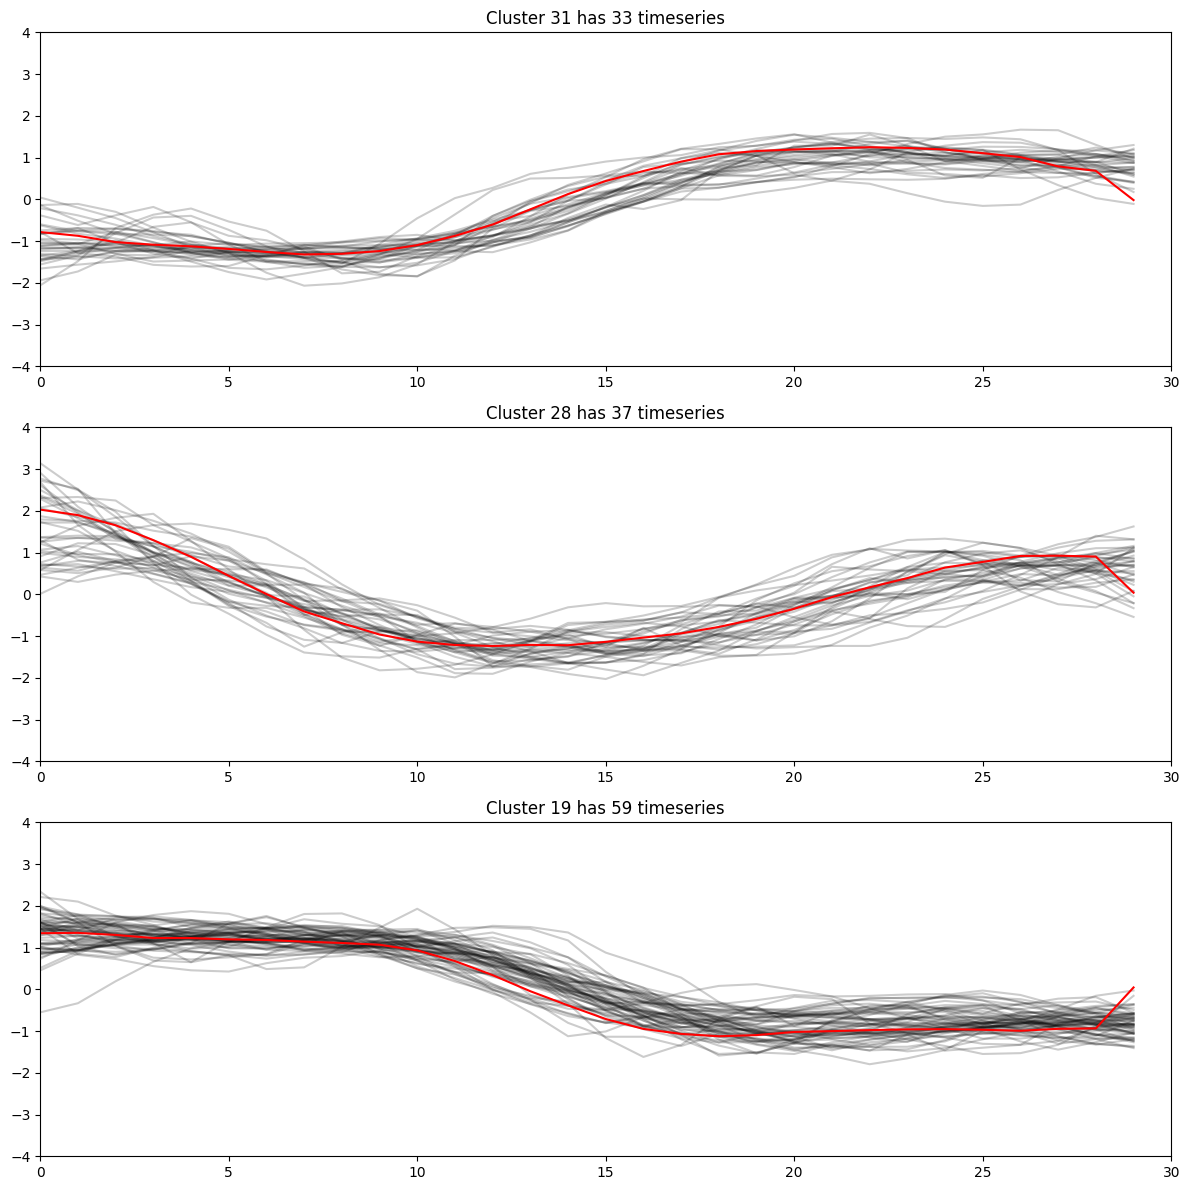

In [110]:
# plot
nc=3
sz=30

plt.figure(figsize=(12, nc * 4))
for (yi, cl) in enumerate([31,28,19]):
    plt.subplot(nc, 1, 1 + yi)
    for xx in train_cl[y_pred == cl]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
    plt.plot(trained_ks.cluster_centers_[cl].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title(
        f"Cluster {str(cl)} has {str(train_cl[y_pred == cl].shape[0])} timeseries"
    )

plt.tight_layout()
plt.show()

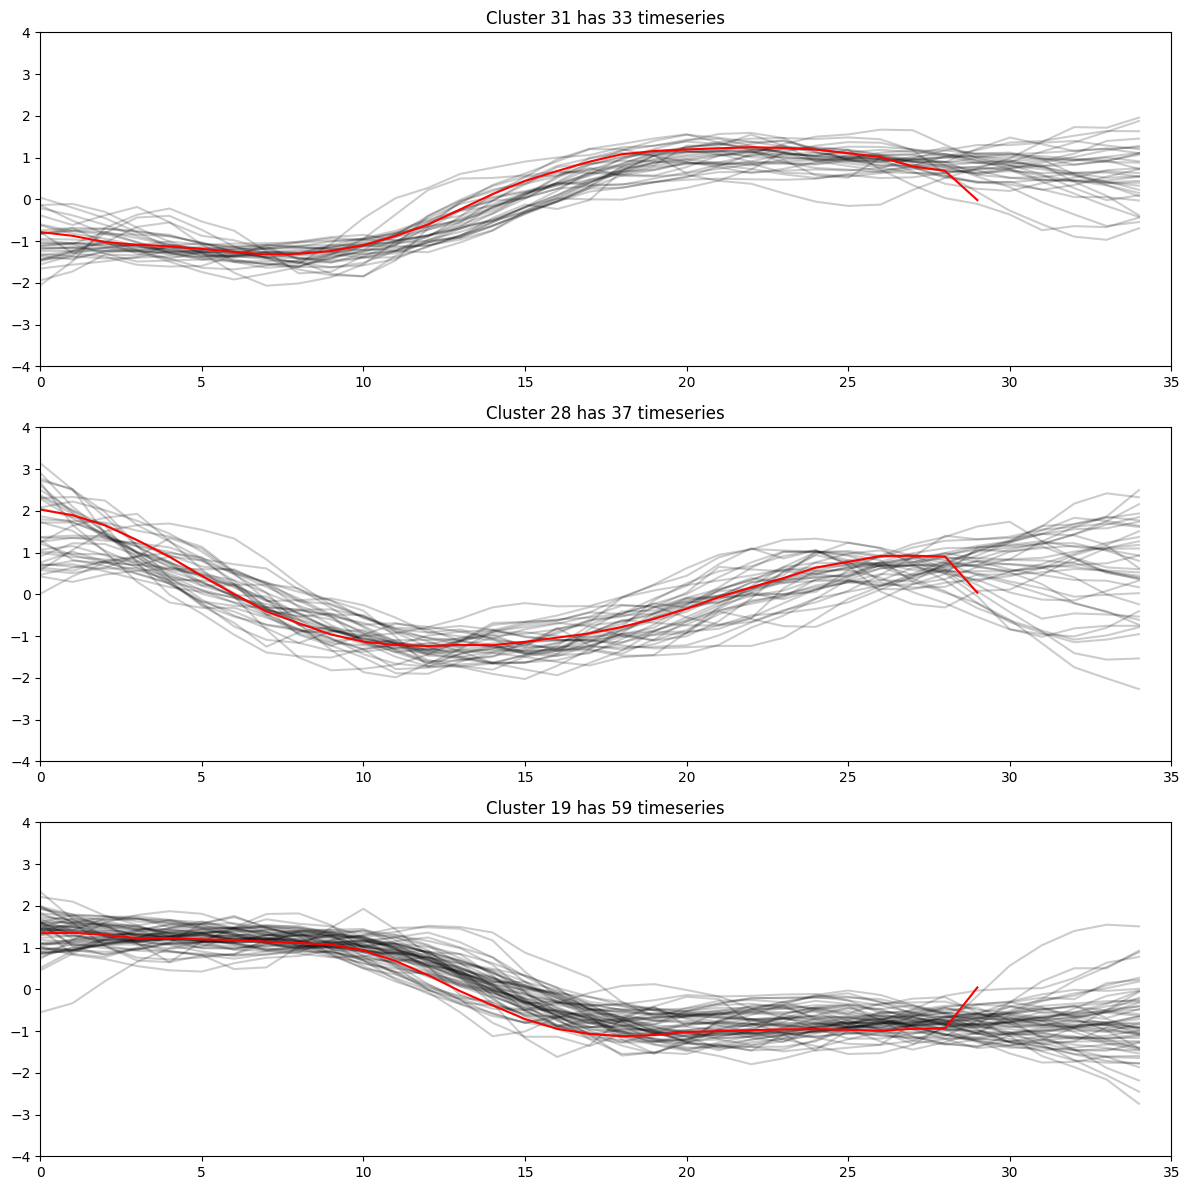

In [111]:
# plot
nc=3
sz=35

plt.figure(figsize=(12, nc * 4))
for (yi, cl) in enumerate([31,28,19]):
    plt.subplot(nc, 1, 1 + yi)
    cl_df = train_nn[y_pred == cl].reset_index(drop=True)
    for xx in range(len(cl_df)):
        plt.plot(cl_df.iloc[xx,:], "k-", alpha=0.2)
    plt.plot(trained_ks.cluster_centers_[cl].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title(
        f"Cluster {str(cl)} has {str(train_nn[y_pred == cl].shape[0])} timeseries"
    )

plt.tight_layout()
plt.show()

по первому кластеру возможно получится предсказывать будущие состояния, но по следующим двум нужно брать отрезки внутри кластера, то есть обрезать временной ряд

сейчас попробую прогнозировать отрезки внутри выбранных временных рядов (хотя у этого и есть свои сложности)

пока непонятно, как затем поменять модель кластеризации, чтобы она определяла кластер по меньшему временному ряду

например, из 30 мин мы оставляем 25 мин для кластеризации и 5 мин для прогноза

- взять центры кластеров, обрезать до 25 мин, обучить новую модель только лишь по центрам?
- в этом случае надо также подобрать новую выборку для обучения моделей прогнозирования (прогнав на данных новую модель кластеризации), т к сейчас прогнозируем только "удобные" случаи
- для начала надо визуализировать, будет ли новая модель кластеризации действительно отбирать такие отрезки, после которых паттерн сохраняется, т к если разброс слишком большой, то обучать модель прогнозирования бессмысленно

# prepare data

In [112]:
# берем всю возможную выборку
def all_data_division(data, column_time='begin', column_value='open', period=60, step=10):
    """Разбиваем строго внутри дня, по {period} минут, с шагом {step}. 

    Args:
        data (DataFrame): should have column_time and column_value.
        period (int, optional): the size of division. Defaults to 60.
        step (int, optional): step in dividing. when step=period, the dividing is consequential (elements are not repeated). Defaults to 10.

    Returns:
        DataFrame: sample of time series. standardized by TimeSeriesScalerMeanVariance().
    """

    df_open = data[[column_time, column_value]]
    df_grouped = df_open.groupby([df_open[column_time].dt.date])
    full_range = []

    for dates in list(df_grouped.groups.keys()):
        df_day = df_grouped.get_group(dates)
        my_list = list(df_day[column_value])

        composite_list = [
            my_list[x : x + period] for x in range(0, len(my_list)-period+1, step)
        ]
        
        full_range += composite_list

    new_df = pd.DataFrame(full_range)

    scaler = TimeSeriesScalerMeanVariance()
    df_norm = scaler.fit_transform(new_df.values)
    print('the size of sample: {0}'.format(df_norm.shape[0]))

    #print('\npreview of 1 time series:')
    #print(train_cl[0])

    return scaler, df_norm

In [113]:
df = pd.read_csv("../data/raw/minutes_21.csv")
df["begin"] = pd.to_datetime(df["begin"])

df['new_col'] = df['open'].rolling(6).mean()
df.dropna(axis=0, inplace=True)
scaler, df_normed = all_data_division(df, column_time='begin', column_value='new_col', period=30, step=10)

trained_ks = KShape.from_hdf5('../models/ks_trained_2.hdf5')
y_pred = trained_ks.predict(df_normed)

train_nn = pd.DataFrame([x.flatten().tolist() for x in df_normed])

the size of sample: 20479


# predict

In [115]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [184]:
# fit an LSTM network
def fit_lstm(X, y, n_batch, nb_epoch, n_neurons, validation_size=0.1, show_progress=1):
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    
    # stateful = True - keep state in memory;
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss, history_val_loss = [], []
    for i in range(nb_epoch):
        #print(i)
        hist = model.fit(X, y, validation_split=validation_size, epochs=1, batch_size=n_batch, verbose=show_progress, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    
    return model,history_loss,history_val_loss


# fit an LSTM network with given validation data (after bootstrap)
def fit_lstm_val(X, y, X_val, y_val, n_batch, nb_epoch, n_neurons, show_progress=1):
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    model = Sequential()
    
    # stateful = True - keep state in memory;
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss, history_val_loss = [], []
    for i in range(nb_epoch):
        #print(i)
        hist = model.fit(X, y, validation_data=(X_val, y_val), epochs=1, batch_size=n_batch, verbose=show_progress, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    
    return model,history_loss,history_val_loss


# inverse transformation
# need to add it later
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # store
        inverted.append(inv_scale)
        
    return inverted

def visualize_result(loss, val_loss):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.title('model loss (MSE)')
    plt.show()

# if error try forecast[0]
def quality_check(test_y, test_X, model, n_batch=1):
    y_test=test_y
    X_test=test_X
    forecast = model.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), batch_size=n_batch, verbose=0)
    print('avg R2: %.2f, avg MSE: %.2f'%tuple(np.mean(pd.DataFrame([[r2_score(y_true, y_predict),\
                                                                    mean_squared_error(y_true, y_predict)] for (y_true, y_predict) \
                                                                    in zip(y_test, forecast)]),axis=0)))

    print('med R2: %.2f, med MSE: %.2f'%tuple(np.median(pd.DataFrame([[r2_score(y_true, y_predict),\
                                                                    mean_squared_error(y_true, y_predict)] for (y_true, y_predict) \
                                                                    in zip(y_test, forecast)]),axis=0)))

In [117]:
for (yi, cl) in enumerate([31,28,19]):
    print(len(train_nn[y_pred == cl]))

42
60
79


In [121]:
#lets start with cluster 19, because it has the most number of examples

cluster=19
predict_period = 5
test = 0.1
n_epochs = 25
n_batch = 1
n_neurons =  10

nn_df = train_nn[y_pred == cluster].reset_index(drop=True)
X, y = np.array(nn_df.iloc[:, :-predict_period]), np.array(nn_df.iloc[:, -predict_period:])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test, random_state=42)

model, history_loss, history_val_loss = fit_lstm(X_train, y_train, n_batch, n_epochs, n_neurons, show_progress=0)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (1, 1, 10)                1440      
                                                                 
 dense_7 (Dense)             (1, 1, 5)                 55        
                                                                 
Total params: 1,495
Trainable params: 1,495
Non-trainable params: 0
_________________________________________________________________
None


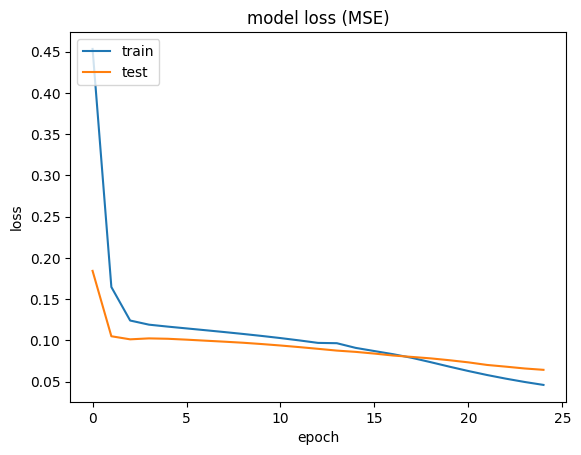

In [119]:
visualize_result(history_loss, history_val_loss)

In [137]:
quality_check(y_test, X_test, model)

avg R2: -0.28, avg MSE: 0.09
med R2: -0.28, med MSE: 0.09


In [ ]:
# выборка слишком маленькая, чтобы обучиться
# применим бутстрэп

# потом лучше вместо увеличения выборки увеличить количество батчей, 
# каждый из которых имеет такой же размер, как изначальная выборка, но собран с помощью рандомного выбора

# + на будущее лучше заменить обычный рандомный набор - набором по распределению, 
# которое выдает ряд с большей вероятностью, если он близок к центру кластера

In [186]:
cluster = 19
bootstrap_times = 3
predict_period = 5
test_set = 0.15
val_set = 0.25
test = test_set + val_set
n_epochs = 40
n_batch = 1
n_neurons =  10


nn_df = train_nn[y_pred == cluster].reset_index(drop=True)
nn_df, df_test = train_test_split(np.array(nn_df), test_size=test, random_state=42)
nn_df = pd.DataFrame(nn_df).reset_index(drop=True)
df_test = pd.DataFrame(df_test).reset_index(drop=True)

#bootstrap part
np.random.seed(0)
lst = np.random.choice(range(len(nn_df)), len(nn_df)*bootstrap_times, replace = True)
repeated = nn_df.iloc[lst,:].reset_index().iloc[:,0].value_counts()
print('repeated rows:\n')
print(repeated)
nn_df = nn_df.iloc[lst,:].reset_index(drop=True)

X_train, y_train = np.array(nn_df.iloc[:, :-predict_period]), np.array(nn_df.iloc[:, -predict_period:])
X, y = np.array(df_test.iloc[:, :-predict_period]), np.array(df_test.iloc[:, -predict_period:])

# validation - for training, test - for final quality evaluation
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=test_set/test, random_state=42)

model, history_loss, history_val_loss = fit_lstm_val(X_train, y_train, X_val, y_val, n_batch, n_epochs, n_neurons, show_progress=0)

repeated rows:

0     9
35    8
1     5
3     5
39    5
36    5
23    5
41    4
20    4
14    4
38    4
11    4
15    4
24    4
34    4
9     4
5     4
10    3
31    3
32    3
40    3
18    3
4     3
13    3
42    3
17    3
46    3
12    3
21    3
19    3
30    2
29    2
43    2
2     2
27    2
6     2
16    2
44    1
28    1
8     1
25    1
37    1
22    1
Name: index, dtype: int64
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (1, 10)                   1440      
                                                                 
 dense_12 (Dense)            (1, 5)                    55        
                                                                 
Total params: 1,495
Trainable params: 1,495
Non-trainable params: 0
_________________________________________________________________
None


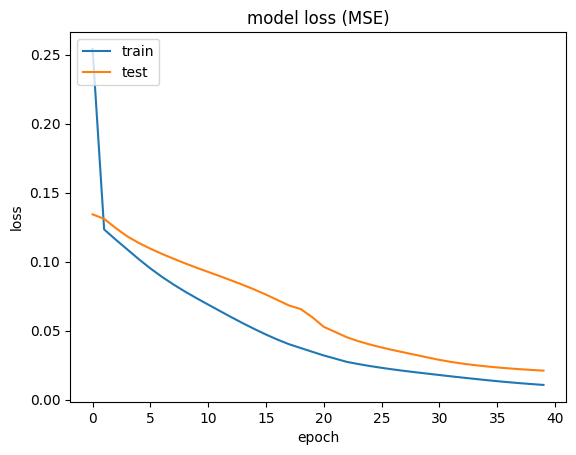

In [187]:
# by this plot we can decide how many epochs we need (1 epoch means training on whole train set once)
visualize_result(history_loss, history_val_loss)

In [188]:
quality_check(y_test, X_test, model)

avg R2: 0.20, avg MSE: 0.03
med R2: 0.55, med MSE: 0.01


In [189]:
forecast = model.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), batch_size=n_batch)

12/12 [==============================] - 0s 12ms/step


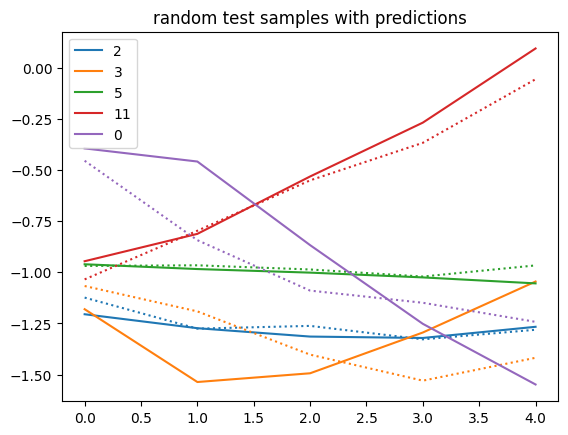

In [204]:
# just 5 random predictions from test sample, which WASN'T used in model training
# if error try forecast[i][0]
n = 5
choices = list(np.random.choice(range(len(y_test)),5,replace=False))

for i in choices:
    p = plt.plot(y_test[i])
    color = p[0].get_color()
    plt.plot(forecast[i], ':', color=color, label='_nolegend_')
plt.legend(choices, loc='upper left')
plt.title('random test samples with predictions')
plt.show()

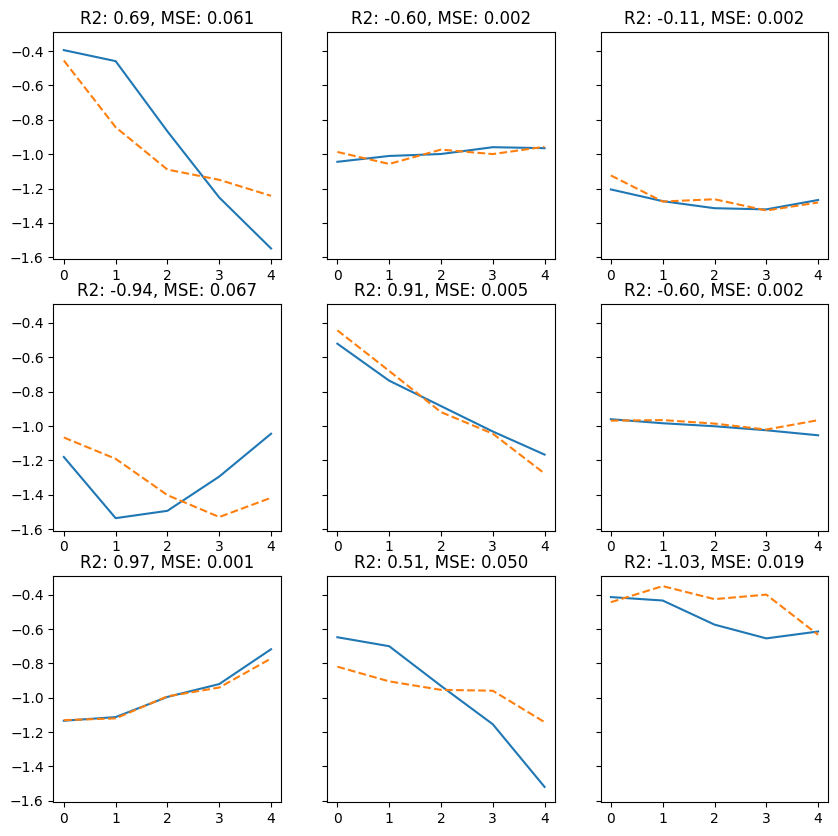

In [201]:
# just first 9 examples from test sample, which WASN'T used in model training
# if error try forecast[i][0]
# for better understanding of R2 metric set sharey=False
fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharey=True)
for i in range(9):
    axs[int(i/3), i%3].plot(y_test[i])
    axs[int(i/3), i%3].plot(forecast[i],'--')
    axs[int(i/3), i%3].title.set_text('R2: %.2f, MSE: %.3f'%(r2_score(y_test[i],forecast[i]),mean_squared_error(y_test[i],forecast[i])))